In [1]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm' 
area = (6716*8964)/4
# Read the CSV file
def load_data(mirror):
    csv_file_path = glob.glob((f'out/{mirror}/*.csv'))  # Replace 'your_file.csv' with the path to your CSV file
    data = []
    for file in csv_file_path:
        read_file = pd.read_csv(file)
        read_file['rel_impro'] = (read_file['pfm']-read_file['pfm_human'])/read_file['pfm_human']
        read_file['rel_impro_iou'] = (read_file['iou']-read_file['iou_human'])/read_file['iou_human']
        data.append(read_file)
    return data


In [2]:
def load_and_group(mirror):
    return pd.concat(load_data(mirror)).groupby('Unnamed: 0').mean().iloc[1:]
a1701 = load_and_group('ANSA-VI-1701_R')
a1700 = load_and_group('ANSA-VI-1700_R')
 
wels = load_and_group('wels-11944_R')



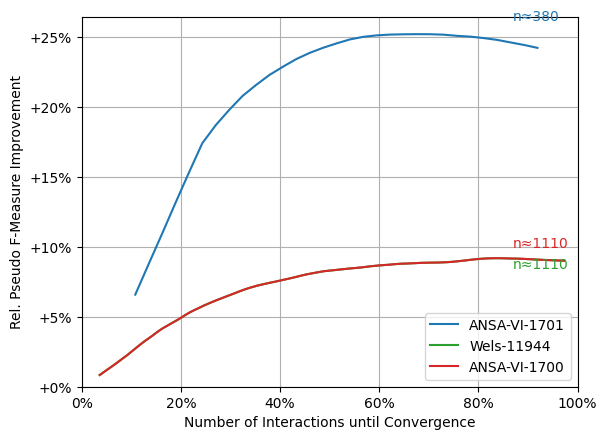

In [3]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
windosize = 8

def smooth_data(data, window_size=windosize):
    return data.rolling(window=window_size, center=True).mean()

label_dict = {'rel_impro': ' $\mathbf{Y}\'$', 'pfm_human': '$\mathbf{\Delta}^\pm$'}
style_dict = {'rel_impro': '-', 'pfm_human': '-.'}

for label in ['rel_impro']:
    # Create line plot using Seaborn
    x_a1701 = np.array(list(range(len(a1701))))/(len(a1701)-1)
    y_a1701 = smooth_data(a1701[label])
    sns.lineplot(x=x_a1701, y=y_a1701, linestyle=style_dict[label], color='tab:blue', label='ANSA-VI-1701')
    plt.annotate(f"n≈{len(a1701)*10}",
                 xy=(.87, y_a1701.iloc[-windosize]*1.05),
                 ha='left',
                 color='tab:blue')

    x_wels = np.array(list(range(len(wels))))/(len(wels)-1)
    y_wels = smooth_data(wels[label])
    sns.lineplot(x=x_wels, y=y_wels, linestyle=style_dict[label], color='tab:green', label='Wels-11944')
    plt.annotate(f"n≈{len(wels)*10}",
                 xy=(.87, y_wels.iloc[-windosize]*0.93),
                 ha='left',
                 color='tab:green')

    x_a1700 = np.array(list(range(len(a1700))))/(len(a1700)-1)
    y_a1700 = smooth_data(a1700[label])
    sns.lineplot(x=x_a1700, y=y_a1700, linestyle=style_dict[label], color='tab:red', label='ANSA-VI-1700')
    plt.annotate(f"n≈{len(a1700)*10}",
                 xy=(.87, y_a1700.iloc[-windosize]*1.1),
                 color='tab:red',
                 ha='left')

plt.xlabel('Number of Interactions until Convergence')
plt.ylabel('Rel. Pseudo F-Measure Improvement')
plt.legend(loc='lower right')
x0, x1 = plt.xlim()
plt.xlim(0, 1)
y0, y1 = plt.ylim()
plt.ylim(0, y1)

x_lim = plt.xlim()
y_lim = plt.ylim()
plt.grid()

def percent_formatter(x, pos):
    return '+{:.0%}'.format(x)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

def percent_formatter(x, pos):
    return '{:.0%}'.format(x)

ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.savefig('performance_comp.pdf')
plt.show()

In [7]:
a1701 = load_data('ANSA-VI-1701_R')
a1700 = load_data('ANSA-VI-1700_R')
wels = load_data('wels-11944_R')

def get_human_input(data):
    max_pfm_human = list(map(lambda x: x['pfm_human'].iloc[-1], data))
    index_of_pfm_bigger_than_human = list(map(lambda x: (x[1]['pfm']>=max_pfm_human[x[0]]).idxmax(), enumerate(data)))
    human_input_dumb = list(map(lambda x: x['human_input'].iloc[-1], data))
    human_input_smart = list(map(lambda x: x[1]['human_input'].iloc[x[0]-1], zip(index_of_pfm_bigger_than_human,data)))
    return human_input_dumb, human_input_smart

data = [
    get_human_input(a1700),
    get_human_input(a1701),
    get_human_input(wels)
]


In [8]:
reduction=list(map(lambda x: (np.array(x[0])-np.array(x[1]))/np.array(x[0]), data))
reduction = list(map(lambda x: np.mean(x),  reduction))

[0.5394300846586098, 0.6563404016289847, 0.7499537294095873]

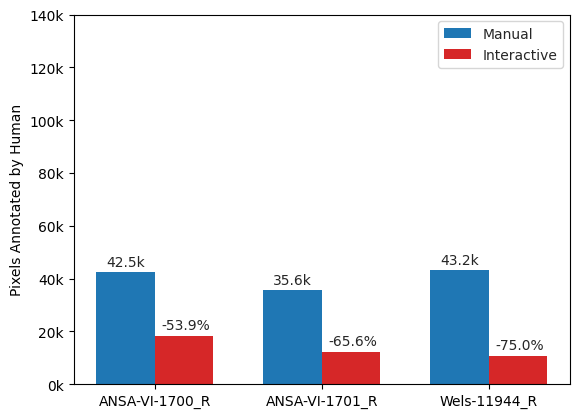

In [9]:
dumb = list(map(lambda x: x[0], data))
smart = list(map(lambda x: x[1], data))

dumb = list(map(lambda x: x[0], data))
smart = list(map(lambda x: x[1], data))

means_male = [np.mean(experiment) for experiment in dumb]
means_female = [np.mean(experiment) for experiment in smart]

x = np.arange(len(means_male))
width = 0.35

fig, ax = plt.subplots()
bars_male = ax.bar(x - width/2, means_male, width, label='Manual', capsize=5, color='tab:blue')
bars_female = ax.bar(x + width/2, means_female, width, label='Interactive', capsize=5, color='tab:red')

ax.set_ylim(0,140000)
sns.set_style("ticks")
ax.set_ylabel('Pixels Annotated by Human')
ax.set_xticks(x)
ax.set_xticklabels(['ANSA-VI-1700_R','ANSA-VI-1701_R', 'Wels-11944_R'])
def format_tick(x, pos):
    return f'{x / 1000:.0f}k'
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_tick))
ax.legend()

for bar, mean in zip(bars_female,reduction):
    ax.annotate(f'{-mean * 100:.1f}%', xy=(bar.get_x() + (bar.get_width()/2)*1.05, bar.get_height()*0.99),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

for bar, mean in zip(bars_male, means_male):
    ax.annotate(f'{mean / 1000:.1f}k', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()*0.99),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.savefig('human_interaction.pdf')